# Construir el LUT, mediante el Acarb/Atag

In [1]:
%pip install opencv-python-headless pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math 


from pycocotools.coco import COCO

In [ ]:
# Rutas de uso general
RUTA_PPAL = os.getcwd()
volumen_img_path = os.path.join(RUTA_PPAL, "Dataset_LookUpTable/img")
coco_tags_path = os.path.join(RUTA_PPAL, "Dataset_LookUpTable/_annotations.coco.json")

In [4]:
lista_archivos = os.listdir(volumen_img_path)

In [12]:
print(lista_archivos)
lista_archivos = [archivo for archivo in lista_archivos if str(archivo).endswith(".jpg")]

['Arepa-pequen-a_jpg.rf.5a3df88178ebe3cb8326abc93b529b41.jpg', 'Areepa-Choclo_png.rf.e7b4c6bd23a7790e14c98db2858e760e.jpg', 'Bun-uelo_png.rf.22603c7e38f215991b28340b60eaa2f4.jpg', 'Papa-Criolla_png.rf.61c23cfcafcdf94dec280a6ec1e5b9f4.jpg', 'Garbanzos_png.rf.9e5d7a1dd9979fbfde843b3c7fb10d65.jpg', 'Hamburguesa_png.rf.4be0ed1f9785b4d6bb16a0d2bdeb6e91.jpg', 'Papa-comun_png.rf.748441ffa7104494f7524a2fb903be58.jpg', '.DS_Store', 'Leche_png.rf.8c358ad7ed820516c3a3ab98a66b5807.jpg', 'Arroz-con-Pollo_png.rf.6601474ea0dc4a4329c9b406ceccfdff.jpg', 'Frijoles_png.rf.433d5f5c67dabc13ebf78eb313ac3495.jpg', 'Arepa-maiz-amarillo_png.rf.148bbf726d235a35f51f408f2f713cbc.jpg', 'Sandia_png.rf.e4464b936789180fe7ed8d72c0c97228.jpg', 'Sopa_png.rf.610de5ddd73c8b5eedd2fae89a0e8a5e.jpg', 'Papas-fritas_png.rf.87002c126deccebeef40d1d301c2025e.jpg', 'Fresas_png.rf.090ac84c42d1658a9d3e3ba201a9ec0c.jpg', 'Guineo_png.rf.282810eb30e9bbdc1b7e7e0e9c362521.jpg', 'Torta_png.rf.0441bc0719e6aaf45209762373af56e7.jpg', 'Pan_pn

In [13]:
def create_instance_masks(image_info, annotations):
    """
    Crea una lista de máscaras binarias, una por cada objeto segmentado en una imagen.
    """
    height, width = image_info["height"], image_info["width"]
    
    masks = []
    areas = {}

    for ann in annotations:
        if ann["image_id"] != image_info["id"]:
            continue

        mask = np.zeros((height, width), dtype=np.uint8)
        category_id = ann["category_id"]

        for seg in ann["segmentation"]:
            coordinates = np.array(seg).reshape((-1, 2))
            cv2.fillPoly(mask, [coordinates.astype(np.int32)], color=category_id) 

        masks.append(mask)
        areas.update({str(category_id): ann["area"]})

    return masks, areas


In [6]:
def get_mask(file_name, coco):
    """
    Obtiene la máscara a partir del archivo de la imagén y el archivo .coco.json
    return (Ancho, Alto)
    """
    # Inicializar el ID de la imagen como None
    img_id = None

    # Iterar sobre todas las imágenes cargadas
    for img_iter in coco.dataset["images"]:
        # Verificar si el nombre de archivo coincide
        if img_iter["file_name"] == file_name:
            img_id = img_iter["id"]
            break

    # Cargar la información de la imagen
    img_info = coco.loadImgs(img_id)[0]

    # Cargar las anotaciones de la imagen
    annIds = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(annIds)

    # Creamos las instancias de las máscaras
    masks, areas = create_instance_masks(img_info, annotations)
    return masks, areas

In [7]:
def visualize_mask(mask):
    plt.imshow(mask)
    plt.colorbar()
    plt.title("Máscara Base")
    plt.show()

# Sanity check

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'11': 35530, '1': 624967}


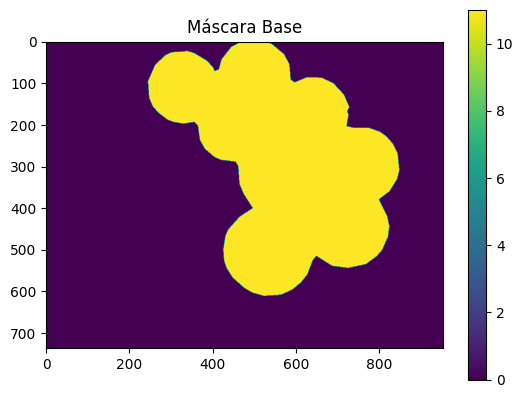

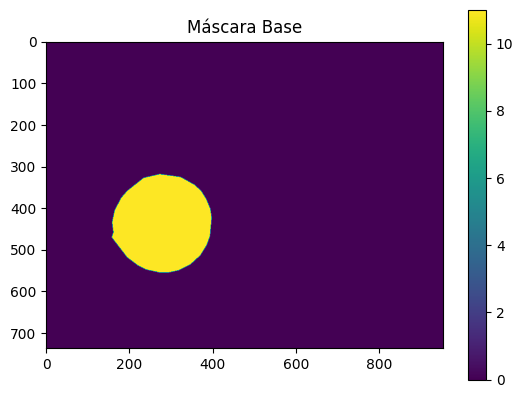

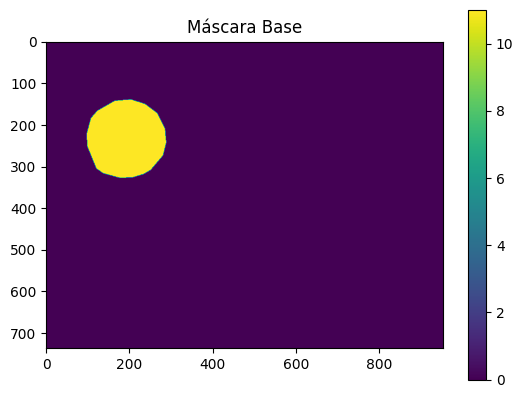

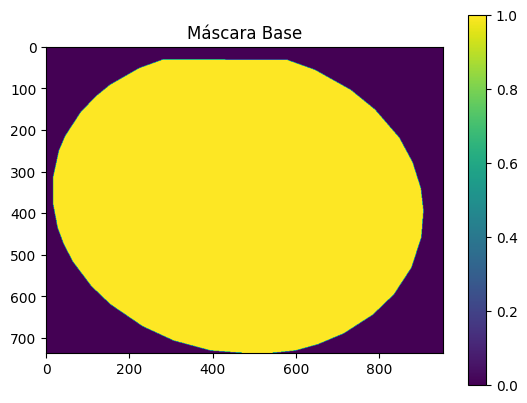

In [8]:
file_name = lista_archivos[2]
coco = COCO(coco_tags_path)
masks, areas = get_mask(file_name, coco)
print(areas)
for mask in masks:
    visualize_mask(mask)

# Cálculo del Acarb/Atag

In [14]:
factor_escala = 1.2
coberturas = {}
for file_name in lista_archivos:
    masks, areas = get_mask(file_name, coco)
    print(areas)
    if a_plato_grando := areas.get('1'):
        areas.pop('1')
        cobertura = math.fsum(list(areas.values())) / a_plato_grando * 100

    elif a_plato_pequeno := areas.get('2'):
        areas.pop('2')
        cobertura = (math.fsum(list(areas.values())) / a_plato_pequeno * 100) * factor_escala

    else:
        continue 

    coberturas[file_name] = round(cobertura, 2)

# Crear DataFrame ordenado
df_coberturas = pd.DataFrame(
    list(coberturas.items()), columns=["imagen", "cobertura (%)"]
)

print("Área de carbohidrato % Área de plato por cada imagen:")
print(df_coberturas)

# Guardar como Excel en la ruta actual
nombre_archivo = "coberturas_exportadas.xlsx"
ruta_salida = os.path.join(os.getcwd(), nombre_archivo)

df_coberturas.to_excel(ruta_salida, index=False)

print(f" Archivo Excel guardado en: {ruta_salida}")



{'7': 78960, '1': 324194}
{'5': 456280, '1': 766043}
{'11': 35530, '1': 624967}
{'31': 25245, '1': 1420800}
{'18': 197548, '1': 610032}
{'20': 181764, '1': 396002}
{'30': 100198, '1': 399672}
{'21': 60760, '1': 255237}
{'9': 378420, '1': 608124}
{'16': 18156, '1': 249713}
{'6': 105105, '2': 140800}
{'36': 340213, '1': 922159}
{'37': 246024, '1': 468162}
{'32': 42768, '1': 168837}
{'1': 579117, '15': 35910}
{'19': 112838, '1': 212850}
{'39': 322853, '1': 896896}
{'28': 45990, '1': 457072}
{'42': 16500, '1': 222456}
{'35': 105754, '1': 533544}
{'1': 214368, '29': 29904}
{'10': 96705, '1': 278784}
{'1': 1067988, '14': 638069}
{'22': 59045, '1': 113906}
{'1': 168142, '27': 374}
{'23': 164630, '1': 217620}
{'34': 367464, '1': 1492324}
{'1': 275502, '40': 97394}
{'26': 4026, '1': 762300}
{'38': 149940, '1': 292320}
{'8': 61503, '1': 115938}
{'4': 70200, '1': 119712}
{'1': 609652, '25': 9483}
{'17': 43575, '1': 1058832}
{'1': 644000, '41': 100283}
{'33': 68970, '1': 123353}
{'24': 159152, '1'